In [1]:
import gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Flatten, Dense, TimeDistributed, \
    SpatialDropout1D, Bidirectional, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

%matplotlib inline

In [2]:
class ConfusionMatrixMetric(tf.keras.metrics.Metric):
    def __init__(self, num_classes, **kwargs):
        super(ConfusionMatrixMetric,self).__init__(name='confusion_matrix_metric',**kwargs)
        self.num_classes=num_classes
        self.total_cm = self.add_weight("total", shape=(num_classes,num_classes), initializer="zeros")
        
    def reset_states(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))
            
    def update_state(self, y_true, y_pred,sample_weight=None):
        self.total_cm.assign_add(self.confusion_matrix(y_true,y_pred))
        return self.total_cm
        
    def result(self):
        return self.process_confusion_matrix()
    
    def confusion_matrix(self,y_true, y_pred):
        y_pred = tf.argmax(y_pred, axis=2)
        y_true = tf.argmax(y_true, axis=2)

        y_pred = tf.reshape(y_pred, [-1])
        y_true = tf.reshape(y_true, [-1])
  
        cm = tf.math.confusion_matrix(
            y_true, 
            y_pred, 
            dtype=tf.float32, 
            num_classes=self.num_classes
        )
        
        return cm
    
    def process_confusion_matrix(self):
        cm = self.total_cm
        diag_part=tf.linalg.diag_part(cm)
        precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
        recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
        f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
        return precision, recall, f1
    
    def fill_output(self,output):
        results=self.result()
        for i in range(self.num_classes):
            output['precision_{}'.format(i)]=results[0][i]
            output['recall_{}'.format(i)]=results[1][i]
            output['f1_{}'.format(i)]=results[2][i]

In [3]:
class SeqModel(tf.keras.Sequential):
    def train_step(self, data):
        x, y = data
        
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(
                y,
                y_pred,
                regularization_losses=self.losses,
            )

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, y_pred)
        output={m.name: m.result() for m in self.metrics[:-1]}
        
        if 'confusion_matrix_metric' in self.metrics_names:
            self.metrics[-1].fill_output(output)

        return output
        
        
    def test_step(self, data):
        x, y = data

        y_pred = self(x, training=False)
        loss = self.compiled_loss(
            y,
            y_pred,
            regularization_losses=self.losses,
        )

        self.compiled_metrics.update_state(y, y_pred)
        output={m.name: m.result() for m in self.metrics[:-1]}
        
        if 'confusion_matrix_metric' in self.metrics_names:
            self.metrics[-1].fill_output(output)    
        
        return output

In [4]:
df = pd.read_csv('../data/data.csv')

In [5]:
df.head()

,word,tag
0,Pengamat,O
1,politik,O
2,dari,O
3,Universitas,B-ORGANIZATION
4,Gadjah,I-ORGANIZATION


In [6]:
sentences = []
cnt = 1

for i in df.itertuples():
    sentences.append(cnt)
    
    if '.' in str(i.word):
        cnt += 1
        
df['sentence #'] = sentences
df.head()

,word,tag,sentence #
0,Pengamat,O,1
1,politik,O,1
2,dari,O,1
3,Universitas,B-ORGANIZATION,1
4,Gadjah,I-ORGANIZATION,1


In [7]:
agg_func = lambda s: [(w, t) for w, t in zip(s['word'].values.tolist(), s['tag'].values.tolist())]
grouped = df.groupby('sentence #').apply(agg_func)
sentences = [s for s in grouped]

In [8]:
words = list(set(df['word'].values))
words.append('PADDING')
num_words = len(words)
tags = list(set(df['tag'].values))
num_tags = len(tags)

In [9]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate([tag for tag in tags if tag != 'O'])}
tag2idx['O'] = len(tags)-1

In [10]:
tag2idx

{'U-ORGANIZATION': 0,
 'U-QUANTITY': 1,
 'L-ORGANIZATION': 2,
 'L-PERSON': 3,
 'L-QUANTITY': 4,
 'B-TIME': 5,
 'L-LOCATION': 6,
 'U-TIME': 7,
 'B-PERSON': 8,
 'B-QUANTITY': 9,
 'B-ORGANIZATION': 10,
 'I-LOCATION': 11,
 'L-TIME': 12,
 'U-PERSON': 13,
 'U-LOCATION': 14,
 'B-LOCATION': 15,
 'I-PERSON': 16,
 'I-ORGANIZATION': 17,
 'I-QUANTITY': 18,
 'I-TIME': 19,
 'O': 20}

In [11]:
num_words

13031

In [12]:
max_len = 60
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx['O'])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [13]:
np.array(y).shape

(4892, 60, 21)

In [14]:
x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=1)

In [15]:
model = gensim.models.Word2Vec.load("../checkpoint/w2vec_wiki_id_case")

In [16]:
embedding_matrix = np.zeros((len(words), 400))

for i, w in enumerate(words):
    try:
        embedding_vector = model.wv[w]
        embedding_matrix[i] = embedding_vector
    except:
        embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), 400)

In [17]:
embedding_matrix.shape[1]

400

In [18]:
model = SeqModel([
    Input(shape=(max_len, )),
    Embedding(
        input_dim= embedding_matrix.shape[0], 
        weights=[embedding_matrix], 
        output_dim=embedding_matrix.shape[1], 
        input_length=max_len,
        trainable=False
    ),
    Conv1D(128, 3, activation='relu', padding='same'),
    SpatialDropout1D(0.5),
    Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.5)),
    Dense(num_tags, activation='softmax')
])
model.summary()

Model: "seq_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 400)           5212400   
_________________________________________________________________
conv1d (Conv1D)              (None, 60, 128)           153728    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 60, 128)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 100)           71600     
_________________________________________________________________
dense (Dense)                (None, 60, 21)            2121      
Total params: 5,439,849
Trainable params: 227,449
Non-trainable params: 5,212,400
_________________________________________________________________


In [19]:
f1_score_m = tfa.metrics.F1Score(
    num_classes=num_tags,
    average='micro',
    name='f1_score',
    threshold=0.5
)

In [20]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=0.01)

model.compile(loss=loss, optimizer=optimizer, metrics=[f1_score_m, ConfusionMatrixMetric(num_tags)])

In [21]:
es = tf.keras.callbacks.EarlyStopping(patience=10)

history = model.fit(
    x_train, np.array(y_train),
    validation_data=(x_val, np.array(y_val)),
    epochs=100, verbose=3, callbacks=[es], batch_size=64
)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100


In [22]:
history_dict = history.history

(0.0, 1.0)

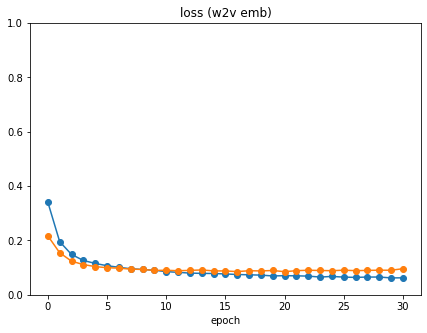

In [23]:
fig=plt.figure(figsize=(7,5))
plt.plot(history_dict['loss'], "-o")
plt.plot(history_dict['val_loss'], "-o")
plt.title('loss (w2v emb)')
plt.xlabel('epoch')
plt.ylim(0,1)

(0.0, 1.0)

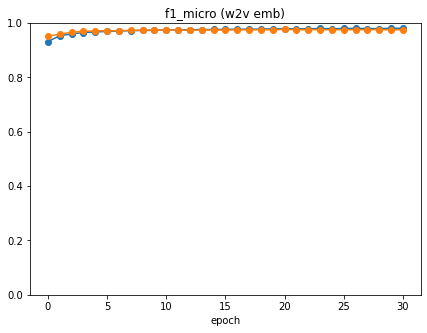

In [24]:
fig=plt.figure(figsize=(7,5))
plt.plot(history_dict['f1_score'], "-o")
plt.plot(history_dict['val_f1_score'], "-o")
plt.title('f1_micro (w2v emb)')
plt.xlabel('epoch')
plt.ylim(0,1)

In [25]:
tags = [t for t in tag2idx]

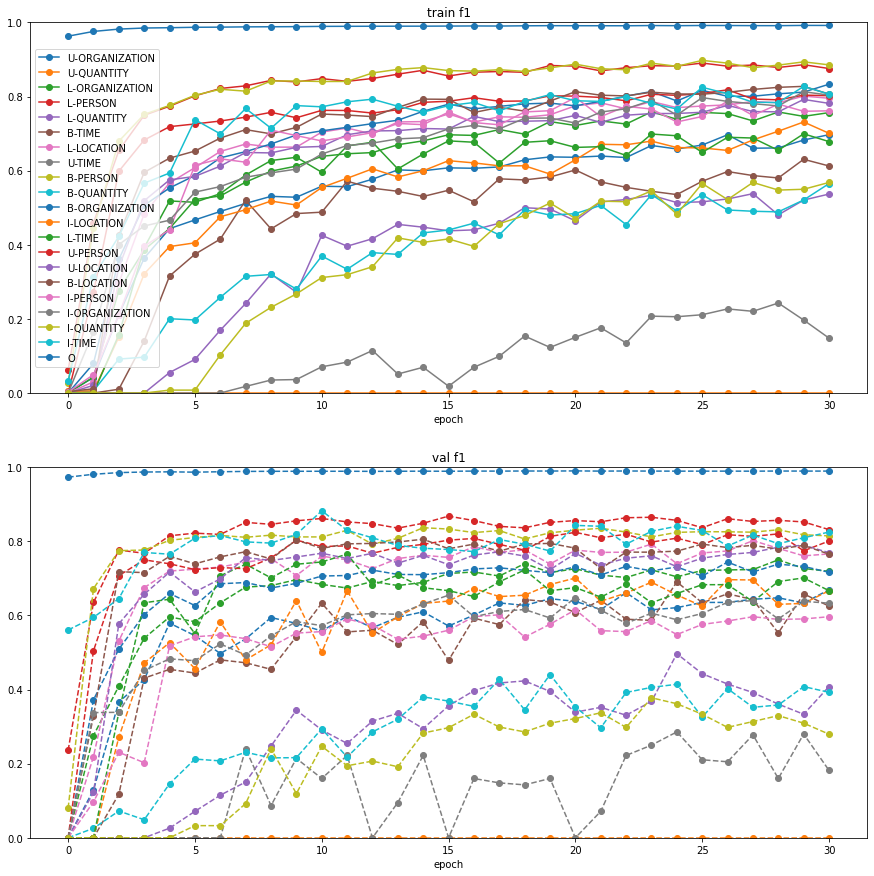

In [26]:
fig,axs=plt.subplots(2,1,figsize=(15,15))
for i in range(num_tags):
    axs[0].plot(history_dict['f1_{}'.format(i)],'-o',label=tags[i])
    axs[1].plot(history_dict['val_f1_{}'.format(i)],'--o',label=tags[i])
axs[0].set_ylim(0,1)
axs[1].set_ylim(0,1)
    
axs[0].set_title('train f1')
axs[1].set_title('val f1')

axs[0].set_xlabel('epoch')
axs[1].set_xlabel('epoch')

axs[0].legend()

Text(0.5, 1.0, 'Val f1 score in the last 10 epochs')

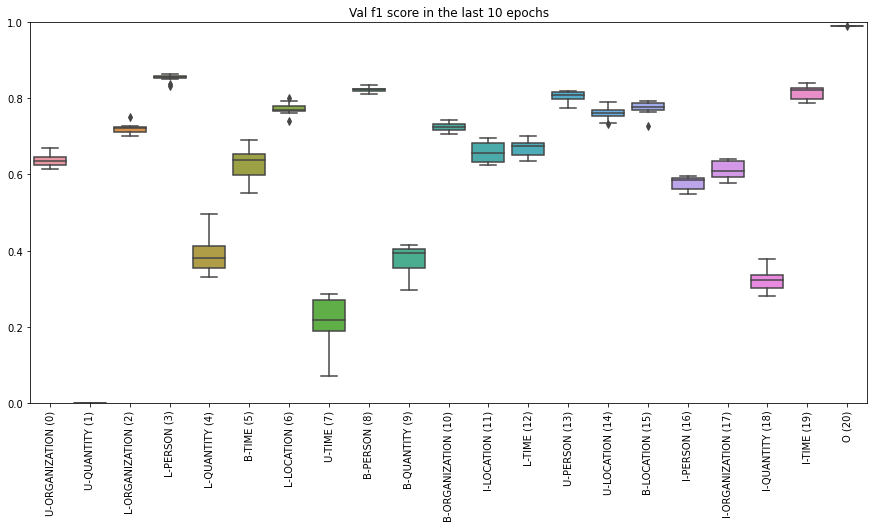

In [27]:
fig=plt.figure(figsize=(15,7))
f1s=pd.DataFrame({i:history_dict['val_f1_{}'.format(i)][-10:] for i in range(21)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
plt.xticks(range(num_tags),['{} ({})'.format(tags[i],i) for i in range(num_tags)])
plt.xticks(rotation=90)
plt.ylim(0,1)
plt.title('Val f1 score in the last 10 epochs')

In [28]:
y_pred=model(x_test)
y_pred_tags=np.argmax(y_pred, -1)

In [29]:
cm = ConfusionMatrixMetric(num_tags)
_ = cm.update_state(y_test,y_pred)

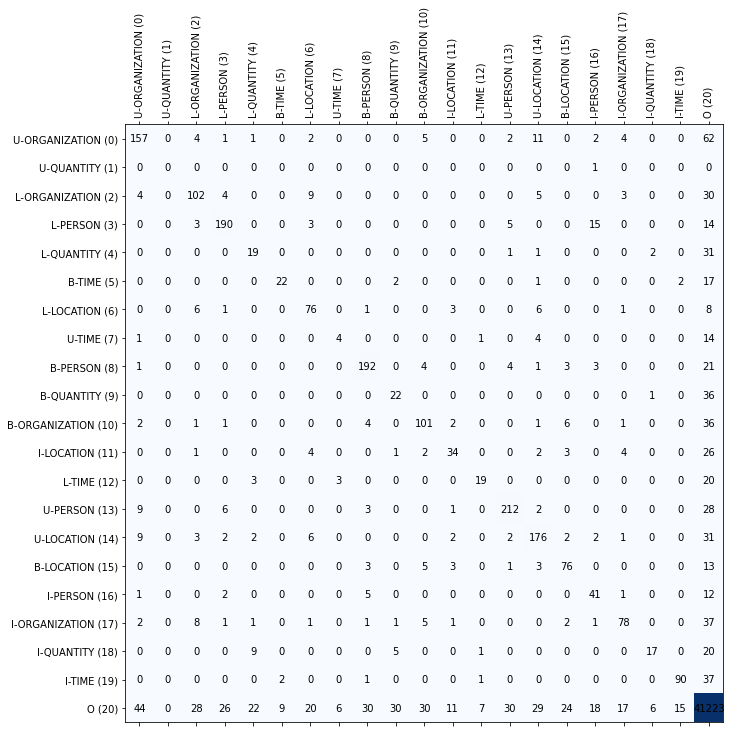

In [30]:
fig, ax = plt.subplots(figsize=(11,11))

cm_matrix = cm.total_cm.numpy().astype(np.int32)

ax.matshow(cm_matrix, cmap=plt.cm.Blues)

for i in range(num_tags):
    for j in range(num_tags):
        c = cm_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center')

plt.xticks(range(num_tags),['{} ({})'.format(tags[i],i) for i in range(num_tags)])
plt.yticks(range(num_tags),['{} ({})'.format(tags[i],i) for i in range(num_tags)])
plt.xticks(rotation=90)
plt.show()

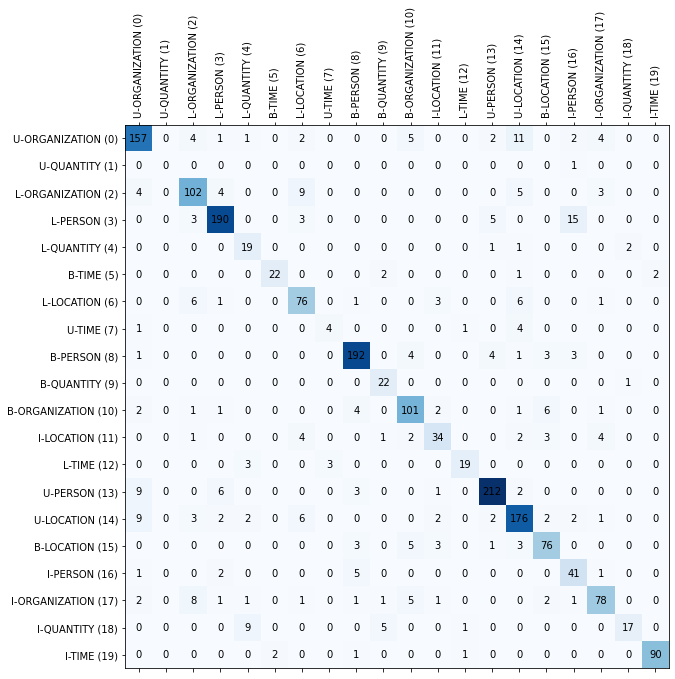

In [31]:
new_tags = tags[:-1]

fig, ax = plt.subplots(figsize=(10,10))

cm_matrix = cm.total_cm.numpy().astype(np.int32)
cm_matrix = np.delete(cm_matrix, (20), axis=0)
cm_matrix = np.delete(cm_matrix, (20), axis=1)

ax.matshow(cm_matrix, cmap=plt.cm.Blues)

for i in range(num_tags-1):
    for j in range(num_tags-1):
        c = cm_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center')
        
plt.xticks(range(num_tags-1),['{} ({})'.format(new_tags[i],i) for i in range(num_tags-1)])
plt.yticks(range(num_tags-1),['{} ({})'.format(new_tags[i],i) for i in range(num_tags-1)])
plt.xticks(rotation=90)
plt.show()

In [32]:
from sklearn.metrics import f1_score

In [33]:
preds = []
actuals = []

for i, xt in enumerate(x_test):
    p = model.predict(np.array([xt]))
    p = np.argmax(p, axis=-1)
    y_true = np.argmax(np.array(y_test), axis=-1)[i]
    
    for true, pred in zip(y_true, p[0]):
        actuals.append(true)
        preds.append(pred)
        
print(f1_score(preds, actuals, average='micro'))
print(precision_score(preds, actuals, average='micro'))
print(recall_score(preds, actuals, average='micro'))

0.9730018165304268
0.9730018165304268
0.9730018165304268


In [34]:
print(classification_report(actuals, preds, target_names=tags, ))

                precision    recall  f1-score   support

U-ORGANIZATION       0.68      0.63      0.65       251
    U-QUANTITY       0.00      0.00      0.00         1
L-ORGANIZATION       0.65      0.65      0.65       157
      L-PERSON       0.81      0.83      0.82       230
    L-QUANTITY       0.33      0.35      0.34        54
        B-TIME       0.67      0.50      0.57        44
    L-LOCATION       0.63      0.75      0.68       102
        U-TIME       0.31      0.17      0.22        24
      B-PERSON       0.80      0.84      0.82       229
    B-QUANTITY       0.36      0.37      0.37        59
B-ORGANIZATION       0.66      0.65      0.66       155
    I-LOCATION       0.60      0.44      0.51        77
        L-TIME       0.66      0.42      0.51        45
      U-PERSON       0.82      0.81      0.82       261
    U-LOCATION       0.73      0.74      0.73       238
    B-LOCATION       0.66      0.73      0.69       104
      I-PERSON       0.49      0.66      0.57  

/Users/sahrul/miniconda3/envs/ner/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
preds = []
actuals = []

for i, xt in enumerate(x_test):
    p = model.predict(np.array([xt]))
    p = np.argmax(p, axis=-1)
    y_true = np.argmax(np.array(y_test), axis=-1)[i]
    
    if 13030 in list(xt):
        first_pad_idx = list(xt).index(13030)
        _zip = zip(y_true[:first_pad_idx], p[0][:first_pad_idx])
    else:
        _zip = zip(y_true, p[0])
    
    for true, pred in _zip:
        actuals.append(true)
        preds.append(pred)

print(f1_score(preds, actuals, average='micro'))
print(precision_score(preds, actuals, average='micro'))
print(recall_score(preds, actuals, average='micro'))

0.9177105682054122
0.9177105682054122
0.9177105682054122


In [37]:
print(classification_report(actuals, preds, target_names=tags))

                precision    recall  f1-score   support

U-ORGANIZATION       0.68      0.63      0.65       251
    U-QUANTITY       0.00      0.00      0.00         1
L-ORGANIZATION       0.65      0.65      0.65       157
      L-PERSON       0.81      0.83      0.82       230
    L-QUANTITY       0.33      0.35      0.34        54
        B-TIME       0.67      0.50      0.57        44
    L-LOCATION       0.63      0.75      0.68       102
        U-TIME       0.31      0.17      0.22        24
      B-PERSON       0.80      0.84      0.82       229
    B-QUANTITY       0.36      0.37      0.37        59
B-ORGANIZATION       0.66      0.65      0.66       155
    I-LOCATION       0.60      0.44      0.51        77
        L-TIME       0.66      0.42      0.51        45
      U-PERSON       0.82      0.81      0.82       261
    U-LOCATION       0.73      0.74      0.73       238
    B-LOCATION       0.66      0.73      0.69       104
      I-PERSON       0.49      0.66      0.57  

In [36]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]

print('{:15}{:15}\t {}\n'.format('word', 'actual', 'pred'))
print('-'*40)

for w, true, pred in zip(x_test[i], y_true, p[0]):
    print('{:15}{:15}\t {}'.format(words[w], tags[true], tags[pred]))

word           actual         	 pred

----------------------------------------
Kapal-kapal    O              	 O
modern         O              	 O
juga           O              	 O
menggunakan    O              	 O
haluan         O              	 O
yang           O              	 O
serupa         O              	 O
dengan         O              	 O
moncong        O              	 O
hidung         O              	 O
lumba-lumba    O              	 O
yang           O              	 O
dirancang      O              	 O
dengan         O              	 O
pola           O              	 O
yang           O              	 O
memperlancar   O              	 O
aliran         O              	 O
air            O              	 O
untuk          O              	 O
meningkatkan   O              	 O
kecepatan      O              	 O
kapal          O              	 O
sebagaimana    O              	 O
halnya         O              	 O
lumba-lumba    O              	 O
.              O              	 O
PAD